<a href="https://colab.research.google.com/github/samuel0711/image-anomaly-detection/blob/main/isolation_tcc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [110]:
import io
import sys
import os
import gc
import shutil
import numpy as np
import matplotlib.pyplot as plt
from skimage import io as skio
import torch
from torch import nn #neural networks
import torch.nn.functional as F
from torchvision.utils import save_image


import time

#Carregamento de Dados
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score


if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir("/content/drive/My Drive/Colab Notebooks")
    sys.path.append('/content/drive/My Drive/Colab Notebooks')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [111]:
args = {
    'epoch':75,          #Numero de épocas
    'lr':5e-4,            #Taxa de aprendizado
    'weight_decay':5e-4,  #Penalidade L2 (Regularização)
    'batch_size': 50,     #Tamanho do batch
    'num_workers': 2
}

if torch.cuda.is_available():
  args['device'] = torch.device('cuda')
else:
  args['device'] = torch.device('cpu')

print(args['device'])


train_set = np.load('train_dataset.npy', allow_pickle = True)/255.0
test_set = np.load('test_dataset.npy', allow_pickle = True)/255.0

cuda


In [112]:
print('Treino\nMédia: ',train_set.mean(),'\t Desvio Padrão: ',train_set.std(),'\n\n')
print('Teste\nMédia: ',test_set.mean(),'\t Desvio Padrão: ',test_set.std())

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


Treino
Média:  0.4165 	 Desvio Padrão:  inf 


Teste
Média:  0.441 	 Desvio Padrão:  inf


In [113]:
train_set = torch.from_numpy(train_set)
test_set = torch.from_numpy(test_set)

isolation_forest = IsolationForest(n_estimators = 50, contamination=float(0.2))

In [114]:
dataset = np.concatenate((train_set, test_set))

dataset = np.reshape(dataset,(dataset.shape[0], dataset.shape[1]*dataset.shape[2]))

isolation_forest.fit(dataset)

IsolationForest(contamination=0.2)

In [115]:
'''transform_train = transforms.Compose([
    transforms.Normalize((train_set.mean(), ), (train_set.std(), ))
])

transform_test = transforms.Compose([
    transforms.Normalize((test_set.mean(), ), (test_set.std(), ))
])
  
# image
train_set = transform_train(train_set)#.permute(1,2,0)
test_set = transform_test(test_set)#.permute(1,2,0)'''

'transform_train = transforms.Compose([\n    transforms.Normalize((train_set.mean(), ), (train_set.std(), ))\n])\n\ntransform_test = transforms.Compose([\n    transforms.Normalize((test_set.mean(), ), (test_set.std(), ))\n])\n  \n# image\ntrain_set = transform_train(train_set)#.permute(1,2,0)\ntest_set = transform_test(test_set)#.permute(1,2,0)'

In [116]:
train_loader = DataLoader(train_set, 
                          batch_size=args['batch_size'], 
                          shuffle=True, 
                          num_workers=args['num_workers'])

test_loader = DataLoader(test_set, 
                         batch_size=args['batch_size'], 
                         shuffle=True, 
                         num_workers=args['num_workers']) 

In [117]:
#Define the Convolutional Autoencoder
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
       
        #Encoder
        self.conv1 = nn.Conv2d(1, 32, 3, padding = 1)  #in_channel, out_channel, kernel_size
        self.conv2 = nn.Conv2d(32, 64, 3, padding = 1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding = 1) 
        self.pool = nn.MaxPool2d(2) #kernel_size, stride
       
        #Decoder
        self.t_conv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(32, 1, 2, stride=2)


    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = self.pool(x)
        x = F.leaky_relu(self.conv2(x))
        x = self.pool(x)
        x = F.leaky_relu(self.conv3(x))
        x = self.pool(x)
        x = F.leaky_relu(self.t_conv1(x))
        x = F.leaky_relu(self.t_conv2(x))
        x = torch.sigmoid(self.t_conv3(x))
              
        return x


#Instantiate the model
model = ConvAutoencoder()


# **Treinando**

In [118]:
from torch import optim

criterio = nn.MSELoss().to(args['device'])
optimizer = optim.Adam(model.parameters(), lr=args['lr'])
model.to(args['device'])

ConvAutoencoder(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
  (t_conv3): ConvTranspose2d(32, 1, kernel_size=(2, 2), stride=(2, 2))
)

In [119]:
def save_decod_img(img, output, epoch, name):
    img = img.view(img.size(0), 1, img.shape[2], img.shape[3])
    output = output.view(output.size(0), 1, output.shape[2], output.shape[3])
    error = output.view(output.size(0), 1, output.shape[2], output.shape[3]) - img.view(img.size(0), 1, img.shape[2], img.shape[3])
    save_image(img, './imgs_tcc/{}_imagem_image{}.png'.format(name,epoch))
    save_image(output, './imgs_tcc/{}_output_image{}.png'.format(name,epoch))
    save_image(error, './imgs_tcc/{}_error_image{}.png'.format(name,epoch))

## Treino ( Somente com imagens não-anomalas)

In [120]:
def train(train_loader, model, epoch, name):
  ###################
  # treinando o modelo #
  ###################
  model.train()
  
  start = time.time()

  tns = []

  train_loss = 0.0
  for data in train_loader:
    imagem = data.unsqueeze(1).float()
    imagem = imagem.to(args['device'])

    #imagem = imagem/255.0

    # clear the gradients of all optimized variables
    optimizer.zero_grad()

    # forward pass
    output = model(imagem)

    # calculando loss
    loss = criterio(output, imagem)

    # backpropagation
    loss.backward()

    # próximo passo
    optimizer.step()

    # update running training loss
    train_loss += loss.item()

    if epoch == args['epoch']:
      for x, y in zip(imagem, output):
          tns.append(np.array(y.squeeze().cpu().data - x.squeeze().cpu().data))

  if epoch % 5 == 0:
    save_decod_img(imagem.cpu().data, output.cpu().data, epoch, name)


  train_loss = train_loss/len(train_loader)

  end = time.time()


  print('########## Train ##########')

  print("Epoca: {}\t Train Loss: {:.6f}, Time: {:.2f}\n".format(epoch, train_loss, end-start))
  #print("Medía do Loss:", epoch_loss_train.mean())

  return train_loss

## Validação ( Somente com imagens anômalas )

In [121]:
def validate(test_loader, model, epoch, name):
  ###################
  # validando o modelo #
  ###################
  model.eval()

  tns = []
  predicts = []
  outliers, inliers = 0, 0
  
  start = time.time()
  
  test_loss = 0.0
  with torch.no_grad():
    for data in test_loader:
      imagem = data.unsqueeze(1).float()
      imagem = imagem.to(args['device'])

      #imagem = imagem/255.0
      # forward pass
      output = model(imagem)

      y = isolation_forest.predict(torch.flatten(output,start_dim=1).cpu().data)
      outliers += list(y).count(-1)
      inliers += list(y).count(1)
      predicts.append(list(y).count(-1)/y.shape[0])

      # calculando loss
      loss = criterio(output, imagem)

      # update running test loss
      test_loss += loss.item()

      if epoch == args['epoch']:
        for x, y in zip(imagem, output):
          tns.append(y.squeeze().cpu().numpy() - x.squeeze().cpu().numpy())

    test_loss = test_loss/len(test_loader)
    end = time.time()

    if epoch % 5 == 0:
      save_decod_img(imagem.cpu().data, output.cpu().data, epoch, name)
    print('########## Validate ##########')

    
    print("Epoca: {}\t Val Loss: {:.6f}, Time: {:.2f}\nAcurácia do Isolation Forest: {:.3f}\t {} Outliers, {} Inliers\n".format(epoch, test_loss, end-start, (sum(predicts)/len(predicts)), outliers, inliers))

    return test_loss, (sum(predicts)/len(predicts))

## Rodando Validação e Treino


In [122]:
train_losses, val_losses = [], []
val_predicts = []

i = 1
for epoch in range(args['epoch']):
  #Train
  train_loss = train(train_loader, model, epoch, 'train')
  train_losses.append(train_loss)

  val_loss, predicts = validate(test_loader, model, epoch, 'test')
  val_losses.append(val_loss)
  val_predicts.append(predicts)

########## Train ##########
Epoca: 0	 Train Loss: 0.032010, Time: 5.87

########## Validate ##########
Epoca: 0	 Val Loss: 0.013467, Time: 4.81
Acurácia do Isolation Forest: 1.000	 1000 Outliers, 0 Inliers

########## Train ##########
Epoca: 1	 Train Loss: 0.006389, Time: 4.84

########## Validate ##########
Epoca: 1	 Val Loss: 0.004298, Time: 4.85
Acurácia do Isolation Forest: 1.000	 1000 Outliers, 0 Inliers

########## Train ##########
Epoca: 2	 Train Loss: 0.004316, Time: 4.86

########## Validate ##########
Epoca: 2	 Val Loss: 0.003793, Time: 4.77
Acurácia do Isolation Forest: 1.000	 1000 Outliers, 0 Inliers

########## Train ##########
Epoca: 3	 Train Loss: 0.003678, Time: 4.91

########## Validate ##########
Epoca: 3	 Val Loss: 0.003257, Time: 4.78
Acurácia do Isolation Forest: 1.000	 1000 Outliers, 0 Inliers

########## Train ##########
Epoca: 4	 Train Loss: 0.003186, Time: 4.89

########## Validate ##########
Epoca: 4	 Val Loss: 0.002923, Time: 4.82
Acurácia do Isolation Forest

## Teste

In [123]:
#isolation_train =  np.load('isolation_train_dataset.npy', allow_pickle = True)/255.0
#isolation_test = np.load('isolation_test_dataset.npy', allow_pickle = True)/255.0

train_label = np.zeros(train_set.shape[0])
test_label = np.ones(test_set.shape[0])

labels = np.concatenate((train_label, test_label))
dataset = np.concatenate((train_set, test_set))

labels = torch.from_numpy(labels)
dataset = torch.from_numpy(dataset)

In [124]:
dataloader = DataLoader([ [dataset[i], labels[i]] for i in range(len(dataset))],
                        shuffle=True,
                        batch_size=args['batch_size'],
                        num_workers=args['num_workers'])

In [125]:
model.eval()

tns = []
predicts = []
outliers, inliers = 0, 0

start = time.time()

test_loss = 0.0
with torch.no_grad():
  for data in dataloader:
    imagem, label = data
    imagem = imagem.unsqueeze(1).float()
    imagem = imagem.to(args['device'])

    # forward pass
    output = model(imagem)

    y = isolation_forest.predict(torch.flatten(output,start_dim=1).cpu().data)
    outliers += list(y).count(-1)
    inliers += list(y).count(1)
    predicts.append(accuracy_score(label, y))

    # calculando loss
    loss = criterio(output, imagem)

    # update running test loss
    test_loss += loss.item()


  test_loss = test_loss/len(test_loader)
  end = time.time()

  if epoch % 5 == 0:
    save_decod_img(imagem.cpu().data, output.cpu().data, epoch, name)
  print('########## Test ##########')

  
  print("Epoca: {}\t Test Loss: {:.6f}, Time: {:.2f}\nAcurácia do Isolation Forest: {:.3f}\t {} Outliers, {} Inliers\n".format(epoch, test_loss, end-start, (sum(predicts)/len(predicts)), outliers, inliers))


########## Test ##########
Epoca: 74	 Test Loss: 0.004911, Time: 22.91
Acurácia do Isolation Forest: 0.114	 2497 Outliers, 2503 Inliers



## Plot Treino x Teste

Text(0.5, 0, 'Epochs')

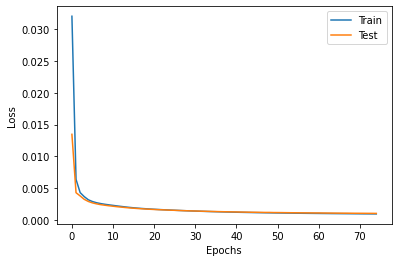

In [126]:
 plt.plot(train_losses, label='Train')
 plt.plot(val_losses, label='Test')
 plt.legend(loc="upper right")
 plt.ylabel('Loss')
 plt.xlabel('Epochs')

Text(0.5, 0, 'Epochs')

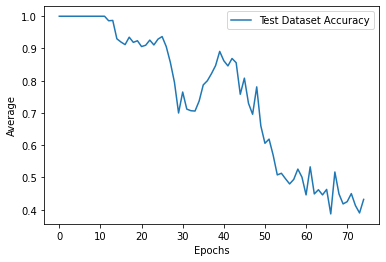

In [127]:
 plt.plot(val_predicts, label='Test Dataset Accuracy')
 plt.legend(loc="upper right")
 plt.ylabel('Average')
 plt.xlabel('Epochs')

## Plot da Imagem Original(normalizada) x Imagem Reconstruída via AutoEncoder Convolucional

In [128]:
n_# obtain one batch of test images
dataiter = iter(train_loader)
images = dataiter.next()

imagem = images.unsqueeze(1).float()
imagem /= 255.0
imagem = imagem.to(args['device'])

# get sample outputs
output = model(imagem)
# prep images for display
images = images.numpy()



# output is resized into a batch of iages
output = output.view(args['batch_size'], 1, 120, 120)
# use detach when it's an output that requires_grad
output = output.detach()#.numpy()



# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(24,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    loss = criterio(output[idx], imagem[idx])
    label = 'Loss value: {:.3f}'
    ax.set_xlabel(label.format(loss) )
    ax.set_title("Reconstructed Image")
    plt.imshow(output[idx].squeeze().cpu(), cmap='gray')
    
# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(24,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    loss = criterio(output[idx], imagem[idx])
    label = 'Loss value: {:.3f}'
    ax.set_xlabel(label.format(loss) )
    ax.set_title("Original Image")
    plt.imshow(images[idx].squeeze(), cmap='gray')


RuntimeError: ignored

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images = dataiter.next()

imagem = images.unsqueeze(1).float()
imagem /= 255.0
imagem = imagem.to(args['device'])

# get sample outputs
output = model(imagem)
# prep images for display
images = images.numpy()



# output is resized into a batch of iages
output = output.view(args['batch_size'], 1, 120, 120)
# use detach when it's an output that requires_grad
output = output.detach()#.numpy()



# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(24,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    loss = criterio(output[idx], imagem[idx])
    label = 'Loss value: {:.3f}'
    ax.set_xlabel(label.format(loss) )
    ax.set_title("Reconstructed Image")
    plt.imshow(output[idx].squeeze().cpu(), cmap='gray')
    
# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(24,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    loss = criterio(output[idx], imagem[idx])
    label = 'Loss value: {:.3f}'
    ax.set_xlabel(label.format(loss) )
    ax.set_title("Original Image")
    plt.imshow(images[idx].squeeze(), cmap='gray')
